In [1]:
from helper_functions.get_processed_data import *
from model_training_functions.kfold_cross_validation import *
from sklearn_extra.cluster import KMedoids

path = 'XY_train (2).csv'

data = pd.read_csv(path)

In [2]:
%%capture 
data = get_processed_data(data)

In [3]:
data.head()

,Has relevent experience,Full time course,training_hours,experience,qualification_score,city_development_index,target
1,1,0,0.779104,0.24,0.418507,0.897,0
4,1,1,0.125373,0.16,0.649334,0.555,1
5,1,0,0.050746,1.00,0.045800,0.897,0
6,1,0,0.083582,0.24,0.449041,0.920,0
7,1,0,0.361194,0.52,0.281194,0.698,1


## Decision Tree

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
from model_training_functions.decision_tree import *


### Tuning Hyperparameters

In [5]:
#max_depth(data, do_plot=True)
#criterion(data, do_plot=True)
#min_samples_leaf(data, do_plot=True)
#min_impurity_decrease(data, do_plot=True)

### Picked model training

In [6]:
#dt_model = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=125, min_impurity_decrease=0.002)
#train_model_by_kfold(data, dt_model)

In [7]:
#plt.figure(figsize=(70,50))
#plot_tree(dt_model, filled=True, class_names=True, max_depth=5, fontsize=35)
#plt.show()

In [8]:
#feature_importance(data)


## Artificial Neural Networks

In [9]:
from sklearn.neural_network import MLPClassifier

### No Hyperparamteres

In [10]:
#ann_model = MLPClassifier()
#train_model_by_kfold(data, ann_model)

In [11]:
from model_training_functions.artificial_neural_networks import *
#max_iterations(data,True)
#hidden_layer_sizes(data,True)
#activations_function(data, True)
#solvers(data, True)
# n_iter_no_change(data, True)

In [12]:
def solver(data, do_plot):
    solvers = ['sgd', 'adam', 'lbfgs']
    all_scores = pd.DataFrame()
    for solver in solvers:
        model = MLPClassifier(max_iter=600,hidden_layer_sizes=(100, 50, 10), activation='relu',solver=solver)
        scores = train_model_by_kfold(data, model)
        scores['solver'] = solver
        all_scores = all_scores.append(scores, ignore_index=True)
    
    if do_plot:
        plot_solver(all_scores)

    return all_scores


In [13]:
def plot_solver(all_scores):
    plt.figure(figsize=(12, 5))
    temp = pd.melt(all_scores, id_vars='solver')
    ax1 = sns.catplot(x='solver', y='value',
                      hue='variable', data=temp, kind='bar', legend=False)
    ax1.set(xlabel='solver Function', ylabel='ROC-AOC Score')
    plt.title('solver Function Tuning')
    plt.ylim(temp['value'].min() - 0.01, temp['value'].max() + 0.01)
    plt.legend()
    plt.show()

In [14]:
#solver(data, True)

In [15]:
#n_iter_no_change(data, True)

### Tuned Model Training

__Note:__  
Hyperparameters functions take a lot of time, so we left them out of the notebook.  
You can import them from- **model_training_functions.decision_tree**


In [16]:
ann_model = MLPClassifier(max_iter=600,hidden_layer_sizes=(100, 50, 10), activation='relu',n_iter_no_change= 10)
train_model_by_kfold(data, ann_model)



Test accuracy: 0.735 +/- 0.018
Training accuracy: 0.745 +/- 0.004


,training_score,test_score
0,0.747030,0.710456
1,0.739535,0.738734
2,0.749187,0.736164
3,0.745505,0.735119
4,0.754177,0.751881
5,0.741847,0.699602
6,0.742955,0.759316
7,0.740305,0.733877
8,0.742657,0.733313
9,0.744039,0.747893


In [20]:
from sklearn.model_selection import GridSearchCV
X_Train = data.drop(columns=['target'])
Y_Train = data['target']

In [21]:
decision_tree = DecisionTreeClassifier(random_state=42)

parameter_options_DT = {"criterion": ['gini', 'entropy'],
                        "max_depth": range(1, 10),
                        "max_features": ['auto', 'sqrt', 'log2', None]}

grid_DT = GridSearchCV(decision_tree, param_grid=parameter_options_DT, cv=10,
                       return_train_score=True, refit=True, scoring='roc_auc')
grid_DT.fit(X_Train, Y_Train)

best_params_DT = grid_DT.best_params_
all_score_DT = pd.DataFrame({'param': grid_DT.cv_results_["params"],
                             'Val_Accuracy': grid_DT.cv_results_["mean_test_score"],
                             'Train_Accuracy': grid_DT.cv_results_["mean_train_score"]})
best_score_DT = all_score_DT[all_score_DT['param'] == best_params_DT]
best_DT_model = grid_DT.best_estimator_

In [22]:
SVM_model = SVC(kernel='linear', random_state=42)
param_grid = {'C': np.arange(1, 2, 0.1),
              'decision_function_shape': ['ovo', 'ovr']
              }

grid_search_SVM = GridSearchCV(estimator=SVM_model,
                               param_grid=param_grid,
                               refit=True,
                               cv=10,
                               return_train_score=True, scoring='roc_auc')

grid_search_SVM.fit(X_Train, Y_Train)

best_params_SVM = grid_search_SVM.best_params_
all_score_SVM = pd.DataFrame({'param': grid_search_SVM.cv_results_["params"],
                              'Val_Accuracy': grid_search_SVM.cv_results_["mean_test_score"],
                              'Train_Accuracy': grid_search_SVM.cv_results_["mean_train_score"]})
best_score_SVM = all_score_SVM[all_score_SVM['param'] == best_params_SVM]

best_model_SVM = grid_search_SVM.best_estimator_

print('Coefficients: \n', best_model_SVM.coef_)
print('Intercepts: \n', best_model_SVM.intercept_)

NameError: name 'SVC' is not defined

In [ ]:
print(best_DT_model)
print(best_model_SVM)

### Confusion Matrix

In [23]:

from sklearn.metrics import confusion_matrix

In [24]:
#Final_Confusion_Matrix = np.zeros((2,2),dtype=int)
#ann_model = MLPClassifier(max_iter=600,hidden_layer_sizes=(100, 50, 10), activation='relu',n_iter_no_change= 10)
#kf = KFold(n_splits=10)
#X = data.drop(columns=['target'])
#y = data['target']
#for train_index, test_index in kf.split(data):
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#    ann_model.fit(X_train,y_train)
#    confusion_temp =confusion_matrix(y_true=y_train , y_pred=ann_model.predict(X_train))
#    for i in range(0,2,1):
#        for j in range(0,2,1):
#            Final_Confusion_Matrix[i,j] += confusion_temp[i,j] 

            
#Final_Confusion_Matrix = Final_Confusion_Matrix/10
#Final_Confusion_Matrix = Final_Confusion_Matrix.round()
#ax= plt.subplot()
#sns.heatmap(Final_Confusion_Matrix, annot=True, fmt='g', ax=ax)
#ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')

#ax.set_title('Confusion Matrix');

In [39]:
def ann_Confusion_Matrix(df,model ,do_plot=False):
    Final_Confusion_Matrix = np.zeros((2,2),dtype=int)    
    kf = KFold(n_splits=10)
    X = data.drop(columns=['target'])
    y = data['target']
    for train_index, test_index in kf.split(data):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ann_model.fit(X_train,y_train)
        confusion_temp =confusion_matrix(y_true=y_train , y_pred=ann_model.predict(X_train))
        for i in range(0,2,1):
            for j in range(0,2,1):
                Final_Confusion_Matrix[i,j] += confusion_temp[i,j] 
    
    if do_plot:
        plot_ann_Confusion_Matrix(Final_Confusion_Matrix)
        
    return Final_Confusion_Matrix/10 

In [40]:
def plot_ann_Confusion_Matrix(Final_Confusion_Matrix):
    #Final_Confusion_Matrix = ((Final_Confusion_Matrix)/10)
    Final_Confusion_Matrix = Final_Confusion_Matrix.round()
    ax= plt.subplot()
    sns.heatmap(Final_Confusion_Matrix, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    

array([[8254.3,  761. ],
       [1624.1, 1095.7]])

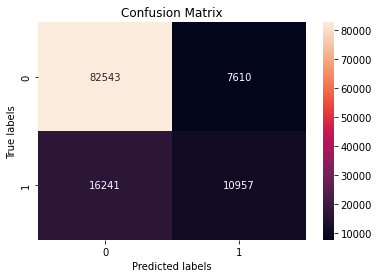

In [41]:

ann_model = MLPClassifier(max_iter=600,hidden_layer_sizes=(100, 50, 10), activation='relu',n_iter_no_change= 10)
ann_Confusion_Matrix(data,ann_model ,True)

In [ ]:
Final_Confusion_Matrix = Final_Confusion_Matrix/10
Final_Confusion_Matrix = Final_Confusion_Matrix.round()
ax= plt.subplot()
sns.heatmap(Final_Confusion_Matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');

## SVM

In [27]:
from sklearn.svm import SVC
from model_training_functions.SVM import *

svm_model= SVC(C=1.2, kernel='linear',decision_function_shape='ovr', random_state=42, probability=True)
#train_model_by_kfold(data, svm_model)

In [ ]:
#C=get_C_SVM(data)
#C.head(10)

In [ ]:
#des = get_decision_function_shape_SVM(data)
#des. head()

In [ ]:
#best_model= get_result_coeff_and_intrec(data) 

## Unsupervised Learning - Clustering

In [ ]:
import seaborn as sns
from model_training_functions.clustering import *
model = KMedoids(n_clusters=4, random_state=42)
model.fit(data.drop('target', axis=1))
data['cluster'] = model.predict(data.drop('target', axis=1))
data_cluster = reduce_dimensionality(data)


In [ ]:
#best_cluster(data, do_plot=True)

In [ ]:
sns.scatterplot(x='PC-1', y='PC-2', hue='cluster', data=data, palette='Accent')


In [ ]:
data.groupby('cluster').mean()

In [ ]:
#df = pd.read_csv(path)
#df = get_processed_data(df)

In [ ]:
new_data=pd.concat([data_cluster,data], axis=1)

In [ ]:
new_data.drop(['PC-2','PC-1','PC-3'], axis=1, inplace=True)

In [ ]:
new_data.head()

In [ ]:
new_data.groupby('cluster').mean()

In [ ]:
plot_data= new_data.groupby('cluster').mean()

In [ ]:
plot_data.transpose().plot(kind='bar', figsize=(15, 8))

# Model Evaluation 

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [29]:
def evaluation_model(df, model,model_name):
    kf = KFold(n_splits=10)
    X = df.drop(columns=['target'])
    y = df['target']
    scores = pd.DataFrame()
    scores.append({'model':model_name},ignore_index=True)
    scores_model = pd.DataFrame()
    for train_index, test_index in kf.split(df):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        # roc_auc scores
        training_score_roc_auc = roc_auc_score(y_true=y_train, y_score=model.predict_proba(X_train)[:, 1])
        test_score_roc_auc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1])    
        #accuracy
        training_score_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_score_accuracy = accuracy_score(y_test, model.predict(X_test)) 
        #precision 
        training_score_precision = precision_score(y_train, model.predict(X_train),average='macro')
        test_score_precision = precision_score(y_test,model.predict(X_test),average='macro')  
        #recall
        training_score_recall = recall_score(y_train, model.predict(X_train),average='macro')
        test_score_recall = recall_score(y_test,model.predict(X_test),average='macro')
        #F1
        training_score_F1 = f1_score(y_train, model.predict(X_train),average='macro')
        test_score_F1 = f1_score(y_test, model.predict(X_test),average='macro')
        #scores apend
        scores_model = scores_model.append({'training score roc auc': training_score_roc_auc, 
                                            'test score roc auc': test_score_roc_auc,
                                            'training score accuracy': training_score_accuracy, 
                                            'test score accuracy': test_score_accuracy,
                                            'training score precision': training_score_precision,
                                            'test_score_precision': test_score_precision,
                                            'training_score_recall': training_score_recall, 
                                            'test_score_recall': test_score_recall,
                                            'training_score_F1': training_score_F1, 
                                            'test_score_F1': test_score_F1}, ignore_index=True)
    scores =pd.concat([scores, scores_model.mean()], axis=1)
    return scores

In [30]:
Evaluation_score = pd.DataFrame()
model_DT = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=125, min_impurity_decrease=0.002)
model_SVC= SVC(C=1, kernel='linear',decision_function_shape='ovr', random_state=42, probability=True)
model_ANN = MLPClassifier(max_iter=600,hidden_layer_sizes=(100, 50, 10), activation='relu',n_iter_no_change= 15)


In [31]:
Evaluation_score=pd.concat([evaluation_model(data, model_DT, 'Decision Tree'),evaluation_model(data, model_SVC, 'SVC'),evaluation_model(data, model_ANN, 'Artificial Neural Networks')], 
                           axis=1,keys=['Decision Tree','SVC','Artificial Neural Networks'])

Evaluation_score.head(20)

C:\Users\ofrifox\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ofrifox\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ofrifox\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ofri

,Decision Tree,SVC,Artificial Neural Networks
,0,0,0
training score roc auc,0.725123,0.612912,0.746559
test score roc auc,0.722876,0.611043,0.735392
training score accuracy,0.798834,0.768234,0.797565
test score accuracy,0.798834,0.768233,0.793542
training score precision,0.715971,0.384117,0.715085
test_score_precision,0.716115,0.384117,0.707366
training_score_recall,0.669079,0.500000,0.657390
test_score_recall,0.669306,0.500000,0.651550
training_score_F1,0.685199,0.434464,0.674646


## Model improvement

In [ ]:
# Get initial data
df = pd.read_csv(path)


In [ ]:
%%capture
df = drop_nan(df)
df = replace_values(df)
df = fill_nan_values(df)
df = extract_features(df)
df = represent_data(df)
df = df.drop(
    columns=[
        'city', 'enrollee_id', 'experience',
        'training_hours', 'relevant_experience_years',
        'Full time course', 'Has relevent experience',
        'Female', 'Male', 'enrollment', 'major_discipline',
            ])

In [ ]:
%%capture



In [ ]:
dt_model = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=100, min_impurity_decrease=0.0001)
train_model_by_kfold(df, dt_model)

In [ ]:
ann_model = MLPClassifier(max_iter=100,hidden_layer_sizes=(800, 50, 10), activation='relu',n_iter_no_change= 15)
train_model_by_kfold(df, ann_model)